# Pareidolia 논문 구현
- Data : Faces-in-Things (FIT) / WIDER-FACE / iCartoonFace
- model(backbone) :  RetinaFace (ResNet50)

- Evaluate & FineTuning  - AP@0.5 on FIT test
  - Off-the-shelf (no FT)
  - Fine-tune on FIT (Train:70 /Test:30)
  - FIne-tune on WIDER-FACE (Train:40 / Val:10 / Test:50)
  - Fine-tune on iCartoonFace
  - FIne-tune on iCartoonFace + FIT
  - Gaussian noise model
  - Frequency decomposition model




# Install



In [1]:
!pip -q install facesinthings pycocotools opencv-python pillow tqdm pandas huggingface_hub

import os, sys, json, math, random, shutil, pathlib, tempfile
from dataclasses import dataclass
import numpy as np
import cv2
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

ROOT = pathlib.Path.cwd()
RF_DIR = ROOT / "Pytorch_Retinaface"
if not RF_DIR.exists():
    !git clone -q https://github.com/biubug6/Pytorch_Retinaface.git
sys.path.append(str(RF_DIR))

from data.config import cfg_mnet, cfg_re50
from models.retinaface import RetinaFace
from layers.functions.prior_box import PriorBox
from utils.box_utils import decode
from utils.nms.py_cpu_nms import py_cpu_nms
from torch import amp

device: cuda


#Config

In [2]:
@dataclass
class EvalCfg:
    backbone: str = "resnet50"   # "resnet50" | "mobile0.25" 가능
    score_thr: float = 0.05
    nms_thr: float = 0.4
    out_dir: str = "rf_fit_outputs"
    viz_n: int = 4               # 비교 시각화 이미지 개수

@dataclass
class TrainCfg:
    epochs: int = 10
    lr: float = 1e-4
    weight_decay: float = 5e-4
    amp: bool = True
    iou_match_thr: float = 0.35  # prior-gt 매칭 임계치

eval_cfg = EvalCfg()
train_cfg = TrainCfg()
os.makedirs(eval_cfg.out_dir, exist_ok=True)

SEED = 2025
np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)


# Weight
- 모델 Weight만 따로 불러와서 적용

In [3]:
WEIGHTS_DIR = RF_DIR / "weights"
WEIGHTS_DIR.mkdir(parents=True, exist_ok=True)

# 1) 폴백이 포함된 ensure_weights
def ensure_weights(backbone="resnet50"):
    WEIGHTS_DIR.mkdir(parents=True, exist_ok=True)
    if backbone == "resnet50":
        fname = "Resnet50_Final.pth"
        fallbacks = [
            ("hf", "py-feat/retinaface", "Resnet50_Final.pth"),
            ("url", "https://storage.openvinotoolkit.org/repositories/open_model_zoo/public/2022.1/retinaface-resnet50-pytorch/Resnet50_Final.pth"),
        ]
    else:  # mobile0.25
        fname = "mobilenet0.25_Final.pth"
        fallbacks = [
            ("hf", "py-feat/retinaface", "mobilenet0.25_Final.pth"),  # 이건 HF에 존재
        ]

    local = WEIGHTS_DIR / fname
    if local.exists():
        return str(local)

    for kind, *rest in fallbacks:
        try:
            if kind == "hf":
                repo_id, filename = rest
                p = hf_hub_download(repo_id=repo_id, filename=filename)
                shutil.copy(p, local)
                print(f"[weights] downloaded via HF -> {local}")
                return str(local)
            elif kind == "url":
                import urllib.request
                print(f"[weights] downloading from URL ...")
                urllib.request.urlretrieve(rest[0], local)
                print(f"[weights] downloaded via URL -> {local}")
                return str(local)
        except Exception as e:
            print(f"[weights] {kind} fallback failed: {e}")

    # 여기까지 오면 실패
    raise FileNotFoundError(
        f"RetinaFace weights not found. Put '{fname}' under '{WEIGHTS_DIR}'. "
        "See the RetinaFace repo README (weights on GDrive)."
    )

#FIT dataset & 70/30 split
- Faces in Things 다운로드 및 훈련셋 분할

In [4]:

from facesinthings import FacesInThings
DATA_ROOT = ROOT / "data_FIT"
DATA_ROOT.mkdir(exist_ok=True, parents=True)
fit = FacesInThings(root_dir=str(DATA_ROOT))  # downloads/caches

meta = fit.metadata.copy()

FILE_CAND = ["image_path", "rel_path", "path", "filepath", "file", "filename", "image", "img"]
BOX_CAND  = ["boxes", "bbox", "bboxes"]
file_col = next((c for c in FILE_CAND if c in meta.columns), None)
box_col  = next((c for c in BOX_CAND  if c in meta.columns), None)
assert file_col is not None, f"file column not found. cols={list(meta.columns)}"
assert box_col  is not None, f"boxes column not found. cols={list(meta.columns)}"

def parse_boxes(v):
    if isinstance(v, str):
        try: v = json.loads(v)
        except Exception: v = eval(v)
    return np.asarray(v, dtype=np.float32).reshape(-1,4) if len(v) else np.zeros((0,4), np.float32)

def to_xyxy(b_xywh):
    if b_xywh.size==0: return np.zeros((0,4), np.float32)
    b = b_xywh.copy()
    b[:,2] = b[:,0] + b[:,2]; b[:,3] = b[:,1] + b[:,3]
    return b

def guess_abs_path(rel):
    p = pathlib.Path(rel)
    if p.is_absolute() and p.exists(): return str(p)
    p1 = pathlib.Path(fit.root_dir) / "FacesInThings" / "images" / rel
    if p1.exists(): return str(p1)
    p2 = pathlib.Path(fit.root_dir) / rel
    if p2.exists(): return str(p2)
    return str(p1)

meta["abs_path"] = meta[file_col].apply(guess_abs_path)
assert any([pathlib.Path(p).exists() for p in meta["abs_path"].head(5)]), "Resolved paths invalid."

# ===== 70/30 고정 (seed 고정) =====
SEED = 42
rng = np.random.default_rng(SEED)

n = len(meta)
idx = rng.permutation(n)

n_train = int(np.floor(n * 0.70))
train_idx = idx[:n_train]
test_idx  = idx[n_train:]

meta["split"] = "test"          # 기본값을 test로 두고
meta.loc[train_idx, "split"] = "train"
meta = meta[meta["split"].isin(["train","test"])].reset_index(drop=True)

print(f"[seed={SEED}] split (70/30)\n", meta["split"].value_counts())


[seed=42] split (70/30)
 split
train    3175
test     1362
Name: count, dtype: int64


# Data pipeline
- Letterbox: 640, BGR mean-sub, pad with mean

In [5]:
IMAGE_SIZE = 640
MEAN = np.array([104,117,123], dtype=np.float32)

def letterbox_resize(img_bgr, boxes_xyxy=None, out_size=IMAGE_SIZE, pad_val=MEAN):
    h0, w0 = img_bgr.shape[:2]
    scale = min(out_size / w0, out_size / h0)
    nw, nh = int(round(w0 * scale)), int(round(h0 * scale))
    # resize
    resized = cv2.resize(img_bgr.astype(np.float32), (nw, nh), interpolation=cv2.INTER_LINEAR)
    # canvas
    canvas = np.ones((out_size, out_size, 3), dtype=np.float32)
    canvas[:] = pad_val  # BGR mean 패딩
    # place centered
    dx = (out_size - nw) // 2
    dy = (out_size - nh) // 2
    canvas[dy:dy+nh, dx:dx+nw, :] = resized
    # boxes transform
    if boxes_xyxy is not None and boxes_xyxy.size:
        b = boxes_xyxy.copy().astype(np.float32)
        b[:, [0,2]] = b[:, [0,2]] * scale + dx
        b[:, [1,3]] = b[:, [1,3]] * scale + dy
    else:
        b = np.zeros((0,4), np.float32)
    return canvas, b, scale, dx, dy, (h0, w0)

class FITRetinaDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img_path = row["abs_path"]
        img = cv2.imread(img_path)
        if img is None: raise FileNotFoundError(img_path)
        # 원본 박스(xywh→xyxy)
        b_xyxy = to_xyxy(parse_boxes(row[box_col]))
        # letterbox
        img_lb, b_lb, scale, dx, dy, (h0,w0) = letterbox_resize(img, b_xyxy, out_size=IMAGE_SIZE, pad_val=MEAN)
        # mean-sub (이미 pad는 mean 값이므로 그대로 뺌)
        img_lb -= MEAN
        img_chw = img_lb.transpose(2,0,1)  # BGR CHW
        tensor = torch.from_numpy(img_chw).float()
        target = {
            "boxes": torch.from_numpy(b_lb).float(),   # 640 letterbox 좌표계
            "image_id": torch.tensor(int(i)),
            "orig_size": torch.tensor([h0,w0]).long(), # 역변환에 사용
            "lb_scale": torch.tensor([scale]),         # 역변환에 사용
            "lb_offset": torch.tensor([dx, dy]).long() # 역변환에 사용
        }
        return tensor, target

def collate(batch):
    imgs = torch.stack([b[0] for b in batch], dim=0)
    tgts = [b[1] for b in batch]
    return imgs, tgts

def make_loaders(batch=8):
    df_tr = meta[meta["split"] == "train"]
    df_te = meta[meta["split"] == "test"]
    has_val = (meta["split"] == "val").any()

    ds_tr = FITRetinaDataset(df_tr)
    ds_te = FITRetinaDataset(df_te)
    dl_tr = torch.utils.data.DataLoader(ds_tr, batch_size=batch, shuffle=True,
                                        num_workers=2, collate_fn=collate, pin_memory=True)
    dl_te = torch.utils.data.DataLoader(ds_te, batch_size=batch, shuffle=False,
                                        num_workers=2, collate_fn=collate, pin_memory=True)

    if has_val:
        df_va = meta[meta["split"] == "val"]
        ds_va = FITRetinaDataset(df_va)
        dl_va = torch.utils.data.DataLoader(ds_va, batch_size=batch, shuffle=False,
                                            num_workers=2, collate_fn=collate, pin_memory=True)
    else:
        ds_va, dl_va = None, None

    return ds_tr, ds_va, ds_te, dl_tr, dl_va, dl_te

train_ds, val_ds, test_ds, train_dl, val_dl, test_dl = make_loaders(batch=32)


#Model build / inference

In [6]:
def strip_prefix(state_dict, prefix="module."):
    if not any(k.startswith(prefix) for k in state_dict.keys()):
        return state_dict
    return {k[len(prefix):]: v for k, v in state_dict.items()}

def build_model(backbone="resnet50", trained_pth=None, phase='train'):
    cfg = cfg_re50 if backbone=="resnet50" else cfg_mnet
    net = RetinaFace(cfg=cfg, phase=phase).to(device).eval()

    if trained_pth is None or not os.path.exists(trained_pth):
        raise FileNotFoundError(
            f"[build_model] Missing RetinaFace weights at: {trained_pth}. "
            f"Call ensure_weights('{backbone}') first."
        )

    ckpt = torch.load(trained_pth, map_location="cpu")
    sd = ckpt.get("state_dict", ckpt)

    # DataParallel로 저장된 weight 처리: 'module.' 접두사 제거
    sd = strip_prefix(sd, "module.")
    # 다른 접두사도 방어적으로 제거
    sd = strip_prefix(sd, "model.")

    # 로드 & 검증
    missing, unexpected = net.load_state_dict(sd, strict=False)
    print(f"[load] {trained_pth} (phase={phase})")
    print(f"missing: {missing[:10]} ... {len(missing)}")
    print(f"unexpected: {unexpected[:10]} ... {len(unexpected)}")

    return net, cfg

@torch.no_grad()
def retinaface_infer_batch(
    net, cfg, imgs, conf_thres=0.05, nms_thres=0.3,
    keep_top_k=100, pre_top_k=1000, score_mode="softmax"
):
    import torch
    from torchvision.ops import nms

    net.eval()
    imgs = imgs.to(device)
    if imgs.dtype == torch.uint8:
        imgs = imgs.float().div(255.0)

    B, _, H, W = imgs.shape
    loc, conf, landm = net(imgs)   # conf: (B,A,2) 로짓(배경/얼굴)
    priors = PriorBox(cfg, image_size=(H, W)).forward().to(device)

    outs = []
    for b in range(B):
        # 1) decode boxes (xyxy in px)
        boxes = decode(loc[b].detach(), priors, cfg['variance'])
        scale = torch.tensor([W, H, W, H], device=boxes.device, dtype=boxes.dtype)
        boxes = (boxes * scale)  # (A,4) torch

        # 2) scores 계산 (정석)
        z = conf[b].detach()  # (A,2) logits
        if score_mode == "softmax":
            # softmax의 class-1 확률
            scores = torch.softmax(z, dim=-1)[:, 1]
        elif score_mode == "sigmoid":
            # 2-class에서 softmax[...,1] 와 동치: sigmoid(z1 - z0)
            scores = torch.sigmoid(z[:, 1] - z[:, 0])
        else:
            # 기본값도 동치식 사용
            scores = torch.sigmoid(z[:, 1] - z[:, 0])

        # 3) 1차 필터 + pre-topk
        keep = scores > conf_thres
        boxes = boxes[keep]
        scores = scores[keep]
        if pre_top_k is not None and boxes.numel() and len(scores) > pre_top_k:
            topk = torch.topk(scores, k=pre_top_k).indices
            boxes = boxes[topk]
            scores = scores[topk]

        # 4) NMS
        if boxes.numel():
            keep_idx = nms(boxes, scores, iou_threshold=nms_thres)
            boxes, scores = boxes[keep_idx], scores[keep_idx]

        # 5) 최종 top-k
        if keep_top_k is not None and boxes.numel() and len(scores) > keep_top_k:
            topk = torch.topk(scores, k=keep_top_k).indices
            boxes, scores = boxes[topk], scores[topk]

        outs.append({
            "boxes":  boxes.detach().cpu().numpy(),
            "scores": scores.detach().cpu().numpy(),
            # 원하면 logits도 넘겨 디버그:
            # "conf_logits": z.detach().cpu().numpy(),
        })
    return outs




#Evaluator
- COCO AP@0.5

In [7]:
def build_coco_gt(dataset):
    from pycocotools.coco import COCO
    ann = {"info":{"description":"FIT split","version":"1.0"},"images":[], "annotations":[], "categories":[{"id":1,"name":"face"}]}
    ann_id = 1
    for i in range(len(dataset.df)):
        row = dataset.df.iloc[i]
        img_path = row["abs_path"]
        img = cv2.imread(img_path); h,w = img.shape[:2]
        ann["images"].append({"id": i, "file_name": img_path, "width": w, "height": h})
        b_xyxy = to_xyxy(parse_boxes(row[box_col]))  # 원본 좌표
        if b_xyxy.size:
            b = b_xyxy.copy()
            b[:,2] = b[:,2]-b[:,0]; b[:,3] = b[:,3]-b[:,1]  # xywh
            for bb in b:
                ann["annotations"].append({
                    "id": ann_id, "image_id": i, "category_id": 1,
                    "bbox": [float(bb[0]), float(bb[1]), float(bb[2]), float(bb[3])],
                    "area": float(bb[2]*bb[3]), "iscrowd": 0
                })
                ann_id += 1
    with tempfile.NamedTemporaryFile(mode="w", suffix=".json", delete=False) as f:
        json.dump(ann, f); p = f.name
    coco = COCO(p); return coco

@torch.no_grad()
def evaluate_AP50(net, cfg, loader, score_thr=0.05, nms_thr=0.4):
    from pycocotools.cocoeval import COCOeval
    ds = loader.dataset
    coco_gt = build_coco_gt(ds)
    results = []
    for imgs, tgts in tqdm(loader, desc="[Eval AP@0.5]"):
        outs = retinaface_infer_batch(net, cfg, imgs, conf_thres=score_thr, nms_thres=nms_thr)
        for out, tgt in zip(outs, tgts):
            image_id = int(tgt["image_id"].item())
            h0, w0 = map(int, tgt["orig_size"].tolist())
            scale = float(tgt["lb_scale"].item())
            dx, dy = map(int, tgt["lb_offset"].tolist())

            boxes = out["boxes"]; scores = out["scores"]
            if len(boxes)==0: continue
            b = boxes.copy().astype(np.float32)
            # 1) letterbox 좌표 -> unpad
            b[:, [0,2]] -= dx
            b[:, [1,3]] -= dy
            # 2) scale 역변환
            b /= np.array([scale, scale, scale, scale], dtype=np.float32)
            # 3) 클리핑
            b[:, 0::2] = np.clip(b[:, 0::2], 0, w0)
            b[:, 1::2] = np.clip(b[:, 1::2], 0, h0)
            # 4) xyxy -> xywh
            b[:,2] = b[:,2] - b[:,0]
            b[:,3] = b[:,3] - b[:,1]
            for bb, sc in zip(b, scores):
                results.append({
                    "image_id": image_id, "category_id": 1,
                    "bbox": [float(bb[0]), float(bb[1]), float(bb[2]), float(bb[3])],
                    "score": float(sc)
                })
    if not results:
        print("[WARN] no detections"); return {"AP_0.5": 0.0}
    with tempfile.NamedTemporaryFile(mode="w", suffix=".json", delete=False) as f:
        json.dump(results, f); rp = f.name
    coco_dt = coco_gt.loadRes(rp)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_eval.params.iouThrs = np.array([0.5], dtype=np.float64)
    coco_eval.evaluate(); coco_eval.accumulate(); coco_eval.summarize()
    return {"AP_0.5": float(coco_eval.stats[0])}

# Finetune Code

In [8]:

from torch import amp as torch_amp
def giou_iou(boxes1, boxes2):
    area1 = (boxes1[:,2]-boxes1[:,0]).clamp(min=0) * (boxes1[:,3]-boxes1[:,1]).clamp(min=0)
    area2 = (boxes2[:,2]-boxes2[:,0]).clamp(min=0) * (boxes2[:,3]-boxes2[:,1]).clamp(min=0)
    lt = torch.max(boxes1[:,None,:2], boxes2[:,:2]); rb = torch.min(boxes1[:,None,2:], boxes2[:,2:])
    wh = (rb - lt).clamp(min=0); inter = wh[...,0]*wh[...,1]
    union = area1[:,None]+area2-inter
    return inter / union.clamp(min=1e-6)

def prior_cxcy(cfg, size=(IMAGE_SIZE,IMAGE_SIZE)):
    return PriorBox(cfg, image_size=size).forward()  # (A,4) normalized

def priors_xyxy_from_cxcy(priors, size):
    H,W = size
    cxcy, wh = priors[:,:2], priors[:,2:]
    xyxy = torch.cat([cxcy-wh/2, cxcy+wh/2], dim=1) * torch.tensor([W,H,W,H], dtype=priors.dtype, device=priors.device)
    return xyxy

def match_priors(gt_xyxy, priors_xyxy, iou_thr=0.35):
    if gt_xyxy.numel()==0:
        return torch.full((priors_xyxy.size(0),), -1, dtype=torch.long, device=priors_xyxy.device)
    iou = giou_iou(priors_xyxy, gt_xyxy)  # (A,G)
    best_iou, best_idx = iou.max(dim=1)
    matched = best_idx.clone(); matched[best_iou < iou_thr] = -1
    return matched

def encode_boxes(gt_boxes_px, priors_norm, variances=(0.1,0.2)):
    """
    gt_boxes_px: (N,4) xyxy in pixels at 640 scale
    priors_norm: (N,4) cx,cy,w,h normalized (0..1)
    RetinaFace 스타일 인코딩: gt를 (W,H)로 정규화해 priors 대비 오프셋/로그비로 표현
    """
    W = H = float(IMAGE_SIZE)
    gt_cxcy = (gt_boxes_px[:,2:]+gt_boxes_px[:,:2]) / 2.0
    gt_wh   = (gt_boxes_px[:,2:]-gt_boxes_px[:,:2]).clamp(min=1e-6)
    gt_cxcy_n = gt_cxcy / torch.tensor([W,H], device=gt_boxes_px.device)
    gt_wh_n   = gt_wh   / torch.tensor([W,H], device=gt_boxes_px.device)

    dxdy = (gt_cxcy_n - priors_norm[:,:2]) / (priors_norm[:,2:] + 1e-6)
    dwh  = torch.log(gt_wh_n / (priors_norm[:,2:] + 1e-6))
    return torch.cat([dxdy/variances[0], dwh/variances[1]], dim=1)

def focal_loss_binary(logits, targets, alpha=0.25, gamma=2.0, reduction="sum"):
    p1 = torch.sigmoid(logits[:,1])
    pt = torch.where(targets==1, p1, 1-p1)
    w  = torch.where(targets==1, alpha, 1-alpha)
    loss = - w * (1-pt).pow(gamma) * torch.log(pt.clamp(min=1e-6))
    return loss.sum() if reduction=="sum" else loss.mean()

def smooth_l1(input, target, beta=1.0/9, reduction="sum"):
    n = torch.abs(input-target)
    loss = torch.where(n<beta, 0.5*n*n/beta, n-0.5*beta)
    return loss.sum() if reduction=="sum" else loss.mean()

def finetune_retinaface(train_dl,
                        val_dl=None,
                        backbone="resnet50",
                        epochs=10, lr=1e-4, wd=5e-4,
                        amp_enabled=True, iou_thr=0.35):
    net, rf_cfg = build_model(backbone, ensure_weights(backbone), phase='train')
    net.train()
    params = [p for p in net.parameters() if p.requires_grad]
    opt = torch.optim.AdamW(params, lr=lr, weight_decay=wd)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    # after (PyTorch 2.x 권장)
    from torch import amp as torch_amp
    scaler = torch_amp.GradScaler("cuda", enabled=(amp_enabled and device.type=="cuda"))

    size = (IMAGE_SIZE, IMAGE_SIZE)
    priors_norm = prior_cxcy(rf_cfg, size=size).to(device)
    priors_xyxy = priors_xyxy_from_cxcy(priors_norm, size).to(device)

    hist = {"epoch":[], "loss":[]}
    if val_dl is not None:
        hist["val_ap50"] = []

    for ep in range(1, epochs+1):
        net.train()
        running = 0.0
        pbar = tqdm(train_dl, desc=f"[Train-FT] epoch {ep}/{epochs}")
        for imgs, tgts in pbar:
            # collate_fn_stack을 쓰면 imgs는 이미 (B,3,H,W) 텐서
            if isinstance(imgs, list):
                imgs = torch.stack(imgs, 0)
            imgs = imgs.to(device, non_blocking=True)
            # ✅ dtype 강제: uint8 -> float32 [0,1], 그 외도 float32로 맞춤
            if imgs.dtype == torch.uint8:
                imgs = imgs.float().div(255.0)
            elif imgs.dtype != torch.float32:
                imgs = imgs.float()
            use_amp = amp_enabled and (device.type == "cuda")
            with torch_amp.autocast(device_type="cuda", enabled=use_amp):
                loc, conf, landm = net(imgs)   # loc:(B,A,4), conf:(B,A,2)
                B, A = conf.shape[0], conf.shape[1]

                loc_t_list, cls_t_list = [], []
                for b in range(B):
                    gtb = tgts[b]["boxes"].to(device)  # xyxy in IMAGE_SIZE pixels
                    match = match_priors(gtb, priors_xyxy, iou_thr=iou_thr)  # (A,)
                    cls_t = torch.zeros((A,), dtype=torch.long, device=device)
                    pos = match >= 0; cls_t[pos] = 1
                    loc_t = torch.zeros((A,4), dtype=torch.float32, device=device)
                    if pos.any():
                        loc_t[pos] = encode_boxes(gtb[match[pos]], priors_norm[pos],
                                                  variances=rf_cfg['variance'])
                    loc_t_list.append(loc_t); cls_t_list.append(cls_t)

                loc_t = torch.stack(loc_t_list, 0)  # (B,A,4)
                cls_t = torch.stack(cls_t_list, 0)  # (B,A)
                pos_mask = (cls_t==1)
                num_pos = pos_mask.sum().clamp(min=1).float()

                conf_2 = conf.reshape(B*A, 2)
                cls_1d = cls_t.reshape(B*A)
                cls_loss = focal_loss_binary(conf_2, cls_1d, alpha=0.25, gamma=2.0, reduction="sum") / num_pos
                loc_loss = smooth_l1(loc[pos_mask], loc_t[pos_mask], beta=1.0/9, reduction="sum") / num_pos
                loss = cls_loss + loc_loss

            opt.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
            running += float(loss.item())
            pbar.set_postfix(loss=f"{float(loss.item()):.4f}", avg=f"{running/max(1,pbar.n):.4f}")
        sch.step()

        # (선택) val 평가: 70/30이면 None일 가능성 높음
        if val_dl is not None:
            net.eval()
            vstats = evaluate_AP50(net, rf_cfg, val_dl,
                                   score_thr=eval_cfg.score_thr, nms_thr=eval_cfg.nms_thr)
            hist["val_ap50"].append(vstats["AP_0.5"])
            print(f"[Val ep{ep}] AP@0.5 = {vstats['AP_0.5'] * 100.0:.2f}")
        hist["epoch"].append(ep); hist["loss"].append(running/max(1,len(pbar)))

    return net, rf_cfg, hist


# FIT 데이터셋으로 파인튜닝 후 평가

In [9]:
print("\n[2] Fine-tune on FIT (70/30), then AP@0.5 on test")
ft_net, ft_cfg, hist = finetune_retinaface(
    train_dl=train_dl,        # ✅ 명시 전달
    val_dl=None,              # ✅ 70/30이라면 보통 None
    backbone=eval_cfg.backbone,
    epochs=5,
    lr=train_cfg.lr,
    wd=train_cfg.weight_decay,
    amp_enabled=train_cfg.amp,
    iou_thr=train_cfg.iou_match_thr
)

print("\n[3] Evaluate fine-tuned on FIT test → AP@0.5")
ft_stats = evaluate_AP50(ft_net, ft_cfg, test_dl,
                         score_thr=eval_cfg.score_thr, nms_thr=eval_cfg.nms_thr)
print("[Fine-tuned]", {"AP_0.5(%)": ft_stats["AP_0.5"] * 100.0})  # ✅ 키로 접근



[2] Fine-tune on FIT (70/30), then AP@0.5 on test


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[load] /content/Pytorch_Retinaface/weights/Resnet50_Final.pth (phase=train)
missing: [] ... 0
unexpected: [] ... 0


[Train-FT] epoch 5/5: 100%|██████████| 100/100 [00:28<00:00,  3.57it/s, avg=1.1373, loss=0.9955]



[3] Evaluate fine-tuned on FIT test → AP@0.5
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


[Eval AP@0.5]: 100%|██████████| 43/43 [00:12<00:00,  3.56it/s]


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.32s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.50 | area=   all | maxDets=100 ] = 0.553
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.553
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.50 | area= small | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.50 | area=medium | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.50:0.50 | area= large | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxDets=  1 ] = 0.490
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxDets= 10 ] = 0.712
 Average Recall     (AR) @[ IoU=0.50:0.50 | area=   all | maxDets=100 ] = 0.721
 Average Recall     (AR) @[ IoU=0.50:0.50 | area= small | maxDets=1

## grad eclip

Loading model (ViT-B/16)...


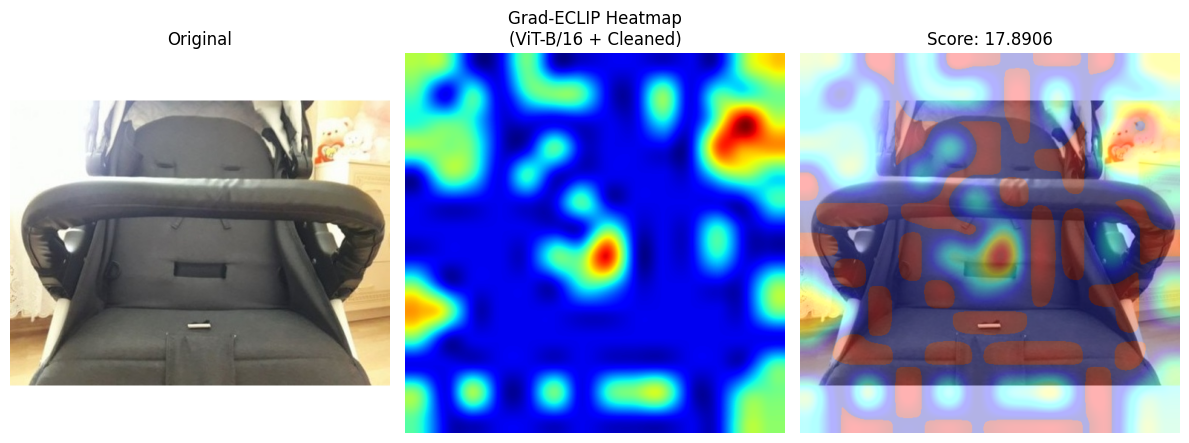

In [14]:
import clip
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# ==========================================
# Grad-ECLIP 구현 (개선된 버전)
# ==========================================
class GradECLIP:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.gradients = None
        self.activations = None
        self.hooks = []

    def _save_gradient(self, module, grad_input, grad_output):
        # Gradient 저장
        self.gradients = grad_output[0]

    def _save_activation(self, module, input, output):
        # Activation 저장
        self.activations = output

    def register_hooks(self):
        # CLIP ViT: 마지막 ResBlock의 LayerNorm(ln_1)에 Hook
        if hasattr(self.model.visual, 'transformer'):
            target_layer = self.model.visual.transformer.resblocks[-1].ln_1
            # Backward Hook (Gradient)
            self.hooks.append(target_layer.register_backward_hook(self._save_gradient))
            # Forward Hook (Activation)
            self.hooks.append(target_layer.register_forward_hook(self._save_activation))
        else:
            # ResNet 계열 (RN50 등)
            target_layer = self.model.visual.layer4
            self.hooks.append(target_layer.register_backward_hook(self._save_gradient))
            self.hooks.append(target_layer.register_forward_hook(self._save_activation))

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

    def generate_heatmap(self, image_tensor, text_tensor, index=None):
        # 1. Forward Pass
        image_features = self.model.encode_image(image_tensor)
        text_features = self.model.encode_text(text_tensor)

        # Normalize
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # 2. Similarity Calculation
        logit_scale = self.model.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()

        if index is None:
            index = torch.argmax(logits_per_image)

        score = logits_per_image[0, index]

        # 3. Backward Pass
        self.model.zero_grad()
        score.backward()

        # 4. Generate Heatmap
        # CLIP ViT 내부 Shape: (Sequence, Batch, Dim) -> (Batch, Sequence, Dim)으로 변환 필요
        if len(self.gradients.shape) == 3:
            # (Seq, Batch, Dim) 확인 및 변환
            if self.gradients.shape[1] == 1 and self.gradients.shape[0] > 1:
                 # LND -> NLD (1, 50, 768) - ViT-B/16의 경우 패치 수 다름
                gradients = self.gradients.permute(1, 0, 2)
                activations = self.activations.permute(1, 0, 2)
            else:
                gradients = self.gradients
                activations = self.activations

            # CLS 토큰(인덱스 0) 제외
            gradients = gradients[0, 1:, :]
            activations = activations[0, 1:, :]

            # Global Average Pooling of Gradients (Weights)
            weights = torch.mean(gradients, dim=0)

            # Weighted Sum
            cam = torch.zeros(activations.shape[0], dtype=torch.float32, device=self.device)
            for i, w in enumerate(weights):
                cam += w * activations[:, i]

            # Reshape to Grid (ViT-B/32는 7x7, ViT-B/16은 14x14)
            side = int(np.sqrt(cam.shape[0]))
            cam = cam.view(side, side)

        else:
            # ResNet: (Batch, Channel, H, W)
            gradients = self.gradients[0]
            activations = self.activations[0]
            weights = torch.mean(gradients, dim=(1, 2))
            cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=self.device)
            for i, w in enumerate(weights):
                cam += w * activations[i, :, :]

        # ReLU & Normalize
        cam = F.relu(cam)

        # Min-Max Scaling (안전장치 추가)
        if cam.numel() > 0:
            cam = cam - cam.min()
            if cam.max() > 0:
                cam = cam / cam.max()

        return cam.detach().cpu().numpy(), score.item()

# ==========================================
# 실행 (수정된 클래스 적용)
# ==========================================
device = "cuda" if torch.cuda.is_available() else "cpu"

# 모델 로드 (개선점 1: ViT-B/16 사용으로 해상도 4배 향상)
print("Loading model (ViT-B/16)...")
clip_model, preprocess = clip.load("ViT-B/16", device=device)
grad_eclip = GradECLIP(clip_model, device)
grad_eclip.register_hooks()

# 테스트 이미지 로드
import random
if 'test_ds' in locals():
    idx = random.randint(0, len(test_ds)-1)
    img_row = test_ds.df.iloc[idx]
    img_path = img_row['abs_path']
else:
    # 예시 경로
    img_path = "image.jpg"

try:
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"파일이 없습니다: {img_path}")

    raw_image = Image.open(img_path).convert("RGB")

    # 텍스트 정의
    text_prompts = ["a face", "an object", "random noise"]
    text_input = clip.tokenize(text_prompts).to(device)

    # 실행
    img_tensor = preprocess(raw_image).unsqueeze(0).to(device)
    heatmap, score = grad_eclip.generate_heatmap(img_tensor, text_input, index=0)

    # 시각화 품질 개선
    # (개선점 2: 노이즈 필터링)
    heatmap_clean = heatmap.copy()
    threshold = 0.3 # 하위 30% 값 제거
    heatmap_clean[heatmap_clean < threshold] = 0
    if heatmap_clean.max() > 0:
        heatmap_clean = heatmap_clean / heatmap_clean.max() # 재정규화

    # (개선점 3: 부드러운 보간 - Bicubic)
    heatmap_resized = cv2.resize(heatmap_clean, raw_image.size, interpolation=cv2.INTER_CUBIC)

    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # 오버레이 투명도 조절
    overlay = cv2.addWeighted(np.array(raw_image), 0.7, heatmap_colored, 0.4, 0)

    # 시각화 출력
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(raw_image)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized, cmap='jet')
    plt.title("Grad-ECLIP Heatmap\n(ViT-B/16 + Cleaned)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title(f"Score: {score:.4f}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"이미지 처리 중 오류 발생: {e}")
    grad_eclip.remove_hooks()
finally:
    if grad_eclip.hooks:
        grad_eclip.remove_hooks()
